In [1]:
# Dependencies
from census import Census
from config import (census_key, gkey)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from us import states
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
# Census API Key
c = Census(census_key, year=2013)

# Census Data

In [2]:
# "B01003_001E" Total Population
# "B19301_001E" Per capita income
# "B25058_001E" Average rent| Median contract rent
# "B19013_001E" Median household income
census_data = c.acs5.get(("B01003_001E", "B19301_001E", "B25058_001E", "B19013_001E" ), 
                         {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19301_001E": "Per Capita Income",
                                      "B25058_001E": "Average Rent",
                                      "B19013_001E": "Median Household Income",
                                      "zip code tabulation area": "Zipcode"})

# Visualize
print(f"Census data ({len(census_pd)} lines) for the year 2016")
census_pd.head()

Census data (33120 lines) for the year 2016


,Population,Median Household Income,Per Capita Income,Average Rent,Zipcode
0,18450.0,12041.0,7380.0,285.0,00601
1,41302.0,15663.0,8463.0,319.0,00602
2,53683.0,15485.0,9176.0,252.0,00603
3,6591.0,15019.0,6383.0,230.0,00606
4,28963.0,16707.0,7892.0,334.0,00610


In [3]:
# Import zip codes from the official databese of US zip codes
zip_codes = pd.read_csv("free-zipcode-database-Primary.csv", dtype="object", encoding="utf-8")

# Visualize
zip_codes = zip_codes[["Zipcode", "City", "State"]]
zip_codes.head()

,Zipcode,City,State
0,00705,AIBONITO,PR
1,00610,ANASCO,PR
2,00611,ANGELES,PR
3,00612,ARECIBO,PR
4,00601,ADJUNTAS,PR


#### Merge Census Data with Zip Codes databaze to assign Census data to a particular city

In [4]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(census_pd, zip_codes, how="left", on=["Zipcode"])

# Save the revised Data Frame as a csv
census_data_complete.to_csv("CensusDataWithCityName.csv", encoding="utf-8", index=False)

# Visualize
census_data_complete.head()

,Population,Median Household Income,Per Capita Income,Average Rent,Zipcode,City,State
0,18450.0,12041.0,7380.0,285.0,00601,ADJUNTAS,PR
1,41302.0,15663.0,8463.0,319.0,00602,AGUADA,PR
2,53683.0,15485.0,9176.0,252.0,00603,AGUADILLA,PR
3,6591.0,15019.0,6383.0,230.0,00606,MARICAO,PR
4,28963.0,16707.0,7892.0,334.0,00610,ANASCO,PR


In [5]:
# Create ascending list of cities to add to a grouped DataFrame as after groupby['City'] we can not call fieald "City"
city_unique = census_data_complete['City'].unique()
city_list = np.sort(city_unique)
print(city_list)

['AARONSBURG' 'ABBEVILLE' 'ABBOT' ... 'ZURICH' 'ZWINGLE' 'ZWOLLE']


In [6]:
grouped_by_city = census_data_complete.groupby(census_data_complete['City'])

population = round(grouped_by_city['Population'].sum(),1)
per_cap_inc = round(grouped_by_city['Per Capita Income'].mean(),1)
rent = round(grouped_by_city['Average Rent'].mean(),1)
household_inc = round(grouped_by_city['Median Household Income'].mean(),1)

city_summary = pd.DataFrame({"Population": population, "Per Capita Income": per_cap_inc,
                            "Average Rent": rent, "City": city_list, "Median Household Income": household_inc})

# Save the revised Data Frame as a csv
city_summary.to_csv("CitySummary.csv", encoding="utf-8", index=False)

print('Key values of USA Sensus grouped by City')
city_summary.head()

Key values of USA Sensus grouped by City


,Average Rent,City,Median Household Income,Per Capita Income,Population
City,,,,,
AARONSBURG,527.0,AARONSBURG,55947.0,19439.0,1303.0
ABBEVILLE,366.8,ABBEVILLE,40417.4,18245.4,53225.0
ABBOT,438.0,ABBOT,36121.0,19646.0,641.0
ABBOTSFORD,433.0,ABBOTSFORD,45609.0,24130.0,2830.0
ABBOTT,471.0,ABBOTT,57361.0,26652.0,1021.0


## NBA teams valuation data

In [7]:
# Import NBA Teams Valuation Data
team_valuations = pd.read_csv("TeamValuations_oy.csv", dtype="object", encoding="utf-8")

# Team valuations 2017
team_valuations = team_valuations[["Item", "City", "State", "Code", "2017"]]
team_valuations.head()

,Item,City,State,Code,2017
0,New York Knicks,NEW YORK,New York,NY,3300
1,Los Angeles Lakers,LOS ANGELES,California,CA,3000
2,Golden State Warriors,SAN FRANCISCO,California,CA,2600
3,Chicago Bulls,CHICAGO,Illinois,IL,2500
4,Boston Celtics,BOSTON,Massachusetts,MA,2200


## Manual corrections of Census Data

#### Reasons for corrections:

######  - Some zipcodes left not filled in Census resulting in distortion of information. This is mostly relevant for big cities such as New York and Los Angeles. Totals like Population was more affected than averages like (Per Capita income)

##### - Data for Toronto was manually changed to Toronto (CANADA) from open sources of information (recalculated to USD)

In [8]:
# Merge NBA valuation data and Census data by City name

valuation = pd.merge(team_valuations, city_summary, how="left", on=["City"])

# Population Correction (source -  Wikipedia)
valuation.loc[0,'Population'] = 8622698
valuation.loc[1,'Population'] = 3999759
valuation.loc[4,'Population'] = 685094
valuation.loc[5,'Population'] = 3999760
valuation.loc[9,'Population'] = 396698
valuation.loc[10,'Population'] = 463347
valuation.loc[12,'Population'] = 2731571
valuation.loc[13,'Population'] = 1626078
valuation.loc[14,'Population'] = 501901
valuation.loc[15,'Population'] = 647805
valuation.loc[17,'Population'] = 693972
valuation.loc[18,'Population'] = 277173
valuation.loc[19,'Population'] = 200544
valuation.loc[21,'Population'] = 704621
valuation.loc[22,'Population'] = 486290
valuation.loc[26,'Population'] = 595351
valuation.loc[28,'Population'] = 422331

# Per Capita income corrections (incl Toronto)
valuation.loc[0,'Per Capita Income'] = 60991
valuation.loc[1,'Per Capita Income'] = 42042
valuation.loc[5,'Per Capita Income'] = 42042
valuation.loc[12,'Per Capita Income'] = 30089

valuation.loc[12,'Average Rent'] = 847

valuation.head(30)

,Item,City,State,Code,2017,Average Rent,Median Household Income,Per Capita Income,Population
0,New York Knicks,NEW YORK,New York,NY,3300,1556.9,88988.9,60991.0,8622698.0
1,Los Angeles Lakers,LOS ANGELES,California,CA,3000,1055.7,46232.6,42042.0,3999759.0
2,Golden State Warriors,SAN FRANCISCO,California,CA,2600,1480.8,80370.7,56259.8,817539.0
3,Chicago Bulls,CHICAGO,Illinois,IL,2500,966.3,56087.7,37423.4,2690705.0
4,Boston Celtics,BOSTON,Massachusetts,MA,2200,1320.8,67972.0,55031.6,685094.0
5,Los Angeles Clippers,LOS ANGELES,California,CA,2000,1055.7,46232.6,42042.0,3999760.0
6,Brooklyn Nets,BROOKLYN,New York,NY,1800,1019.5,49367.5,26437.3,2600812.0
7,Houston Rockets,HOUSTON,Texas,TX,1650,736.8,53997.2,30449.1,2990053.0
8,Dallas Mavericks,DALLAS,Texas,TX,1450,749.2,50097.9,30534.3,1427050.0
9,Cleveland Cavaliers,CLEVELAND,Ohio,OH,1200,561.2,39630.4,21467.1,396698.0


# All NBA teams on Google maps

In [21]:
# Use Google API to retrieve Lat and Lon for NBA team base cities
from config import gkey
lat, lon = [], []
cities = valuation['City']
for city in cities:
    target_url = "https://maps.googleapis.com/maps/api/geocode/json?" \
    "address=%s&key=%s" % (city, gkey)
    geo_data = requests.get(target_url).json()
    lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    lon.append(geo_data["results"][0]["geometry"]["location"]["lng"])

In [22]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
locations = pd.DataFrame({"Lat": lat, "Lon": lon})

team_val = valuation["2017"].astype(float)

In [63]:
# Create a Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=team_val, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = 1.5)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 1000
heat_layer.point_radius = 1.5

# City layer
city_layer = gmaps.symbol_layer(locations, fill_color='rgba(100, 100, 0, 0.2)',
                                stroke_color='rgba(0, 0, 150, 0.5)', scale=2)


In [64]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(city_layer)

fig

Figure(layout=FigureLayout(height='420px'))

### Location of all NBA teams on Google map

## Valuation of teams vs Census data (Population, Income, Expenses)

In [ ]:
# With NYC
x = valuation['Population']
y = valuation['2017'].astype(float)

x1 = valuation['Per Capita Income']
y1 = valuation['2017'].astype(float)

x2 = valuation['Average Rent']
y2 = valuation['2017'].astype(float)

# Clean data from NYC
valuation_wo_nyc = valuation.drop(valuation.index[0])

x3 = valuation_wo_nyc['Per Capita Income']
y3 = valuation_wo_nyc['2017'].astype(float)

x4 = valuation_wo_nyc['Average Rent']
y4 = valuation_wo_nyc['2017'].astype(float)

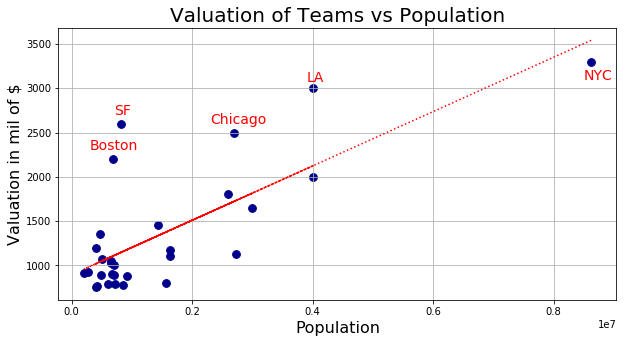

In [9]:
# Valuation vs Population

plt.scatter(x, y, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r:")

# Add other captions on plot
plt.title(f"Valuation of Teams vs Population", size = 20)
plt.xlabel("Population", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(700000, 2700, "SF", fontsize=14, color = "red")
plt.text(2300000, 2600, "Chicago", fontsize=14, color = "red")
plt.text(3900000, 3070, "LA", fontsize=14, color = "red")
plt.text(300000, 2300, "Boston", fontsize=14, color = "red")
plt.text(8500000, 3100, "NYC", fontsize=14, color = "red")

plt.grid()

### As a result of this study we can conclude that there is no visible correlation between Population and Valuation of the team. On this Scatter Plot trend line is mostly driven by Ney York. If we exclude New York from these calculations, there won’t be any visible tendencies on the Plot. 

### And this makes sense because if a place is densely populated by people with low income it is unlikely that they will be willing to spend money on tickets, tv translations and other attributes of a local team.

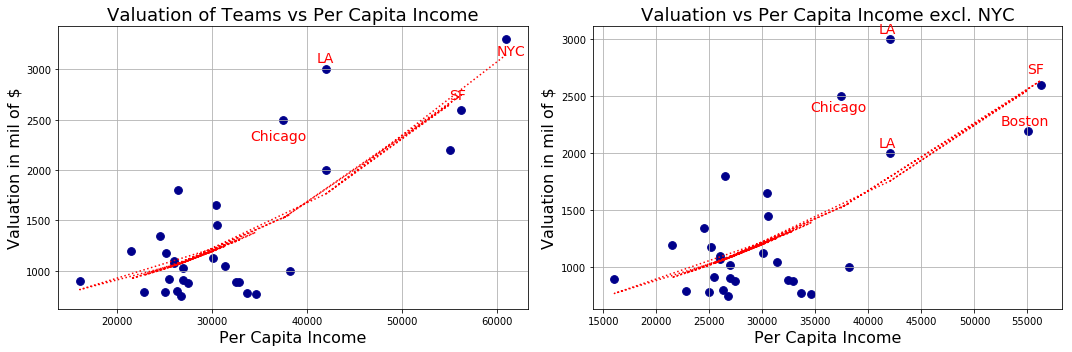

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

# All cities

plt.subplot(1,2,1)
plt.scatter(x1, y1, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"r:")

# Add other captions on plot
plt.title(f"Valuation of Teams vs Per Capita Income", size = 18)
plt.xlabel("Per Capita Income", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(60000, 3140, "NYC", fontsize=14, color = "red")
plt.text(41000, 3070, "LA", fontsize=14, color = "red")
plt.text(55000, 2700, "SF", fontsize=14, color = "red")
plt.text(34000, 2300, "Chicago", fontsize=14, color = "red")
plt.grid()

# Without NYC

plt.subplot(1,2,2)
plt.scatter(x3, y3, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z3 = np.polyfit(x3, y3, 2)
p3 = np.poly1d(z3)
plt.plot(x3,p3(x3),"r:")

plt.title(f"Valuation vs Per Capita Income excl. NYC", size = 18)
plt.xlabel("Per Capita Income", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(41000, 3050, "LA", fontsize=14, color = "red")
plt.text(41000, 2050, "LA", fontsize=14, color = "red")
plt.text(55000, 2700, "SF", fontsize=14, color = "red")
plt.text(34500, 2370, "Chicago", fontsize=14, color = "red")
plt.text(52500, 2250, "Boston", fontsize=14, color = "red")
plt.grid()

plt.tight_layout()                         

### Following Scatter Plots show the relation between Valuation of the team and Per Capita Income.  Some tendencies are already visible on these plots but still we can’t conclude about a certain correlation between these two parameters. This can be partially explained by the thing that “Per Capita Income” is an income per person incl. infants and other dependents who do not take part in decisions about budget spending.

### We excluded NYC on the second Plot as an outlier. And here we already see two groups: SF, LA, Boston, Chicago and all others.

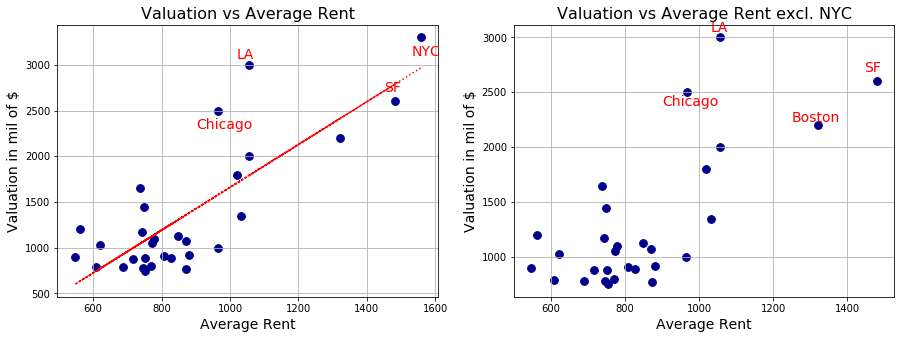

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

# Average Rent - All cities
plt.subplot(1,2,1)
plt.scatter(x2, y2, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.plot(x2,p2(x2),"r:")

# Add other captions on plot
plt.title(f"Valuation vs Average Rent", size = 16)
plt.xlabel("Average Rent", size = 14)
plt.ylabel("Valuation in mil of $", size = 14)
plt.text(1530, 3100, "NYC", fontsize=14, color = "red")
plt.text(1020, 3070, "LA", fontsize=14, color = "red")
plt.text(1450, 2700, "SF", fontsize=14, color = "red")
plt.text(900, 2300, "Chicago", fontsize=14, color = "red")
plt.grid()

# Without NYC

plt.subplot(1,2,2)
plt.scatter(x4, y4, marker="o", s=60, facecolors = "darkblue")

# Add trendline
#z4 = np.polyfit(x4, y4, 2)
#p4 = np.poly1d(z4)
#plt.plot(x4,p4(x4),"r:")

# Add other captions on plot
plt.title(f"Valuation vs Average Rent excl. NYC", size = 16)
plt.xlabel("Average Rent", size = 14)
plt.ylabel("Valuation in mil of $", size = 14)
plt.text(1030, 3050, "LA", fontsize=14, color = "red")
plt.text(1445, 2690, "SF", fontsize=14, color = "red")
plt.text(900, 2380, "Chicago", fontsize=14, color = "red")
plt.text(1250, 2230, "Boston", fontsize=14, color = "red")
plt.grid()

### These Scatter Plots illustrate relation between team Valuation and Rental expense (Median Contract Rent). It looks reasonable that the more people are spending on their rent, the more they are ready to spend on sports entertainments, and it affects team valuations. 

### Again, we excluded NYC as an outlier and a kind of curved tendency becomes visible.
